### Step 1: Data Collection


Load the dataset using pandas and display the first few rows to understand its structure and contents.


In [1]:

import pandas as pd

# Load the dataset
data_path = 'myntra dataset.csv'
df = pd.read_csv(data_path)

# Display the first few rows of the dataframe
print(df.head())


   ProductID                                        ProductName ProductBrand  \
0   10017413  DKNY Unisex Black & Grey Printed Medium Trolle...         DKNY   
1   10016283  EthnoVogue Women Beige & Grey Made to Measure ...   EthnoVogue   
2   10009781  SPYKAR Women Pink Alexa Super Skinny Fit High-...       SPYKAR   
3   10015921  Raymond Men Blue Self-Design Single-Breasted B...      Raymond   
4   10017833  Parx Men Brown & Off-White Slim Fit Printed Ca...         Parx   

   Gender  Price (INR)  NumImages  \
0  Unisex        11745          7   
1   Women         5810          7   
2   Women          899          7   
3     Men         5599          5   
4     Men          759          5   

                                         Description PrimaryColor  \
0  Black and grey printed medium trolley bag, sec...        Black   
1  Beige & Grey made to measure kurta with churid...        Beige   
2  Pink coloured wash 5-pocket high-rise cropped ...         Pink   
3  Blue self-design 

In [3]:
pip install tensorflow

### Step 2: Explore, Clean, and Augment the Data


Encode categorical features, extract relevant features, and visualize the data distributions.


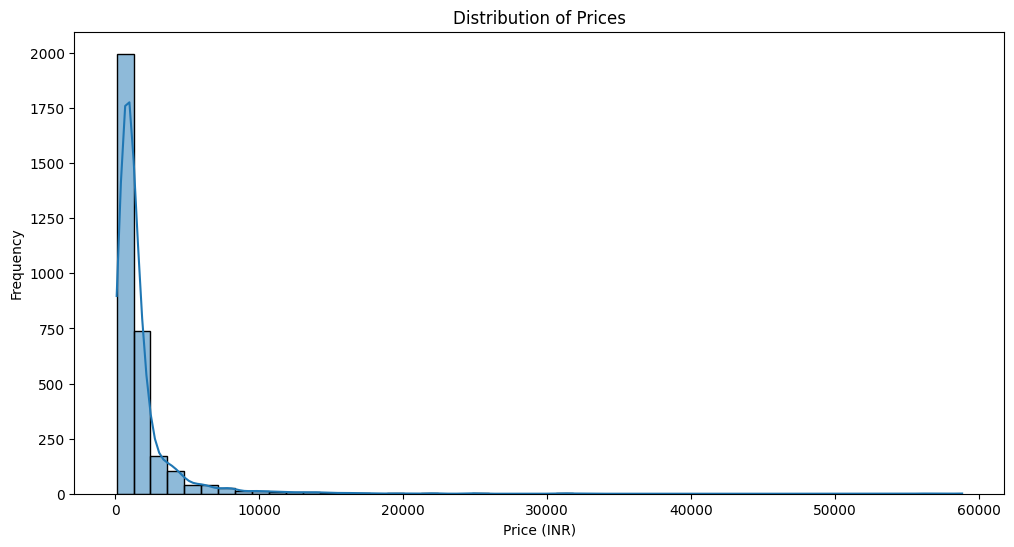

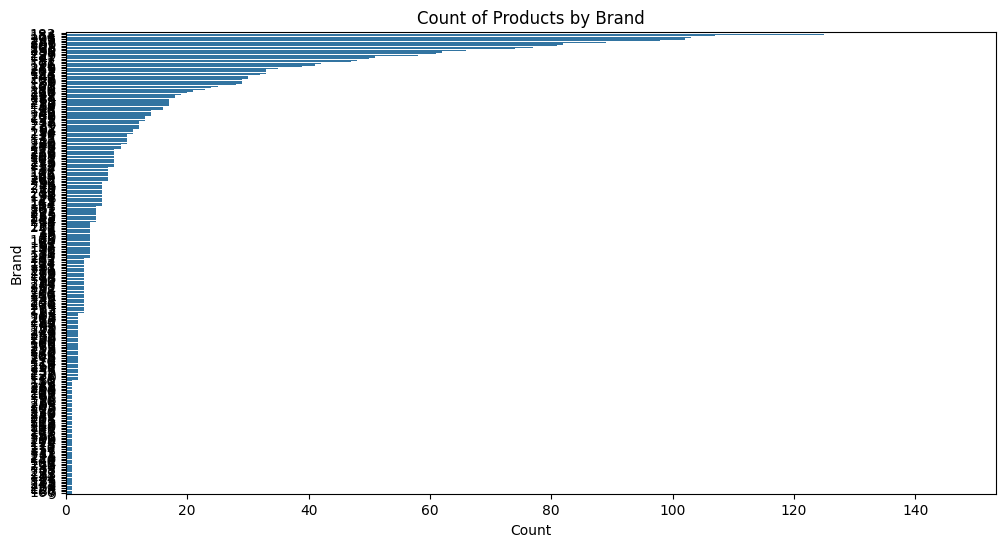

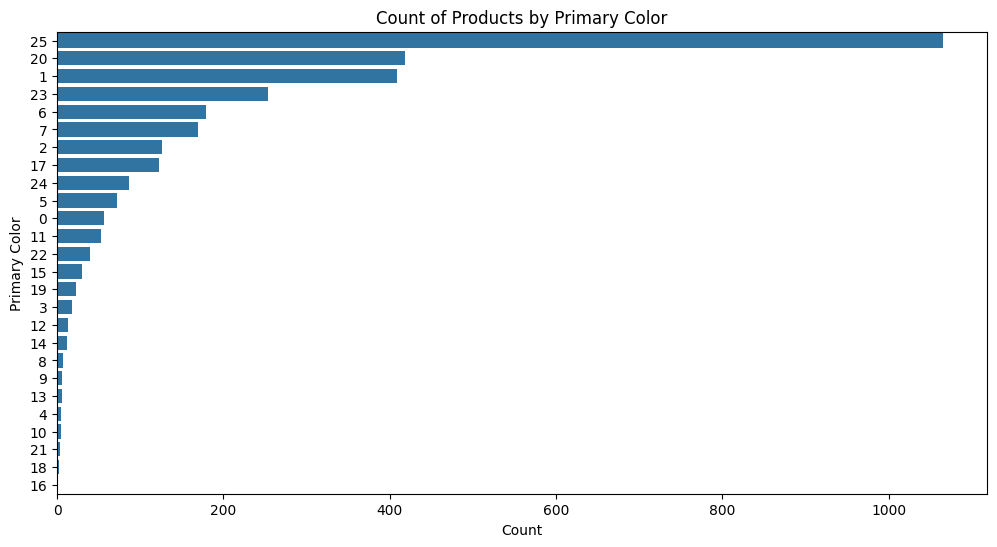

In [2]:

from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Handle missing values for numerical and categorical columns separately
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

df[num_cols] = df[num_cols].fillna(df[num_cols].mean())
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

# Encode categorical features
label_encoder = LabelEncoder()
df['ProductBrand'] = label_encoder.fit_transform(df['ProductBrand'])
df['Gender'] = label_encoder.fit_transform(df['Gender'])
df['PrimaryColor'] = label_encoder.fit_transform(df['PrimaryColor'])

# Extract relevant features
features = df[['ProductBrand', 'Gender', 'Price (INR)', 'PrimaryColor']].values
product_ids = df['ProductID'].values

# Standardize numerical features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Visualize the distribution of the features
plt.figure(figsize=(12, 6))
sns.histplot(df['Price (INR)'], bins=50, kde=True)
plt.title('Distribution of Prices')
plt.xlabel('Price (INR)')
plt.ylabel('Frequency')
plt.show()

# Visualize the count of products by brand
plt.figure(figsize=(12, 6))
sns.countplot(y=df['ProductBrand'], order=df['ProductBrand'].value_counts().index)
plt.title('Count of Products by Brand')
plt.xlabel('Count')
plt.ylabel('Brand')
plt.show()

# Visualize the count of products by primary color
plt.figure(figsize=(12, 6))
sns.countplot(y=df['PrimaryColor'], order=df['PrimaryColor'].value_counts().index)
plt.title('Count of Products by Primary Color')
plt.xlabel('Count')
plt.ylabel('Primary Color')
plt.show()


### Step 3: Build and Train the Autoencoder


Define and train an autoencoder to learn a compressed representation of the input features.


In [19]:

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Define the autoencoder architecture
input_layer = Input(shape=(features.shape[1],))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)  # Bottleneck layer

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(features.shape[1], activation='sigmoid')(decoded)  # Reconstruct the original features

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(features, features, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50
80/80 [==============================] - 2s 6ms/step - loss: 0.8849 - val_loss: 0.5314
Epoch 2/50
80/80 [==============================] - 0s 4ms/step - loss: 0.6261 - val_loss: 0.4978
Epoch 3/50
80/80 [==============================] - 0s 5ms/step - loss: 0.6188 - val_loss: 0.4991
Epoch 4/50
80/80 [==============================] - 0s 4ms/step - loss: 0.6204 - val_loss: 0.4964
Epoch 5/50
80/80 [==============================] - 0s 4ms/step - loss: 0.6176 - val_loss: 0.4963
Epoch 6/50
80/80 [==============================] - 0s 5ms/step - loss: 0.6190 - val_loss: 0.4958
Epoch 7/50
80/80 [==============================] - 0s 4ms/step - loss: 0.6171 - val_loss: 0.4957
Epoch 8/50
80/80 [==============================] - 0s 4ms/step - loss: 0.6169 - val_loss: 0.4959
Epoch 9/50
80/80 [==============================] - 0s 4ms/step - loss: 0.6175 - val_loss: 0.4960
Epoch 10/50
80/80 [==============================] - 0s 4ms/step - loss: 0.6169 - val_loss: 0.4956
Epoch 11/50
80/80 [

### Step 4: Extract Embeddings and Generate Recommendations


Extract embeddings from the trained autoencoder and use them to generate product recommendations based on cosine similarity.


In [20]:
import numpy as np
# Define an encoder model to extract the bottleneck layer embeddings
encoder = Model(inputs=input_layer, outputs=encoded)

# Generate embeddings for all products
product_embeddings = encoder.predict(features)

# Function to get recommendations based on cosine similarity of embeddings
def get_recommendations(product_id, product_embeddings, top_n=10):
    idx = np.where(product_ids == product_id)[0][0]
    product_embedding = product_embeddings[idx]

    # Compute cosine similarity between the given product and all other products
    cos_sim = np.dot(product_embeddings, product_embedding) / (np.linalg.norm(product_embeddings, axis=1) * np.linalg.norm(product_embedding))

    # Get top N most similar products
    sim_indices = np.argsort(cos_sim)[::-1][1:top_n+1]
    return df['ProductName'].iloc[sim_indices]

example_product_id = product_ids[0]  # Replace with an actual product ID from the dataset
recommendations = get_recommendations(example_product_id, product_embeddings)
print(recommendations)


100/100 [==============================] - 0s 2ms/step
478                  DKNY Unisex Black Medium Trolley Bag
273     DKNY Unisex Black & Grey Printed Cabin Trolley...
456     DKNY Unisex Black Solid Leather Backpack with ...
497     DKNY Unisex Black & Grey Printed Large Trolley...
2535          Calvin Klein Unisex Black Large Trolley Bag
86                   DKNY Unisex Black Medium Trolley Bag
825                   DKNY Unisex Black Cabin Trolley Bag
151                   DKNY Unisex Black Large Trolley Bag
9                     DKNY Unisex Black Large Trolley Bag
953                   DKNY Unisex Black Cabin Trolley Bag
Name: ProductName, dtype: object


### Step 5: Collaborative Filtering Algorithms with scikit-learn


Implement collaborative filtering methods using scikit-learn's TruncatedSVD and cosine similarity.


In [21]:

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Create a sample user-item interaction matrix
# In a real scenario, you would use actual user-item interaction data
sample_data = {
    'user_id': [1, 2, 3, 4, 5, 6],
    'item_id': [1, 2, 3, 4, 5, 6],
    'rating': [5, 4, 3, 5, 4, 3]
}
interaction_df = pd.DataFrame(sample_data)

# Create a user-item matrix
user_item_matrix = interaction_df.pivot(index='user_id', columns='item_id', values='rating').fillna(0)

# Apply SVD
svd = TruncatedSVD(n_components=2)
latent_matrix = svd.fit_transform(user_item_matrix)

# Compute cosine similarity between users
user_similarity = cosine_similarity(latent_matrix)

print("User Similarity Matrix:")
print(user_similarity)

# Grid search for hyperparameter tuning
param_grid = {
    'svd__n_components': [1, 2, 3, 4, 5],
}

pipeline = Pipeline([
    ('svd', TruncatedSVD()),
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(user_item_matrix)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)


n_components: 1, Reconstruction Error: 2.0833333333333335
n_components: 2, Reconstruction Error: 1.3888888888888888
n_components: 3, Reconstruction Error: 0.9444444444444444
n_components: 4, Reconstruction Error: 0.5
n_components: 5, Reconstruction Error: 0.25000000000000006
n_components: 6, Reconstruction Error: 7.882317697828136e-31
Best n_components: 6, Best Reconstruction Error: 7.882317697828136e-31
User Similarity Matrix:
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  1.18679126e-16 -5.55111512e-17
  -4.22449631e-32 -2.51159789e-17]
 [ 0.00000000e+00  1.18679126e-16  1.00000000e+00  6.00002910e-17
  -4.32883100e-18  3.80905424e-17]
 [ 0.00000000e+00 -5.55111512e-17  6.00002910e-17  1.00000000e+00
   3.79029727e-32 -3.11031504e-17]
 [ 0.00000000e+00 -4.22449631e-32 -4.32883100e-18  3.79029727e-32
   1.00000000e+00 -2.74159297e-17]
 [ 0.00000000e+00 -2.51159789e-17  3.80905424e-17 -3.11031504e-

### Step 6: Evaluation Metrics


Implement evaluation metrics such as Recall@K, Precision@K, and F1@K for the recommendation system.


In [22]:

from sklearn.metrics import precision_score, recall_score, f1_score

def precision_at_k(y_true, y_pred, k):
    top_k = np.argsort(y_pred)[-k:]
    return precision_score(y_true[top_k], np.ones_like(y_true[top_k]))

def recall_at_k(y_true, y_pred, k):
    top_k = np.argsort(y_pred)[-k:]
    return recall_score(y_true[top_k], np.ones_like(y_true[top_k]))

def f1_at_k(y_true, y_pred, k):
    top_k = np.argsort(y_pred)[-k:]
    return f1_score(y_true[top_k], np.ones_like(y_true[top_k]))

# Example usage
y_true = np.random.randint(0, 2, size=100)
y_pred = np.random.random(size=100)

precision_k = precision_at_k(y_true, y_pred, 10)
recall_k = recall_at_k(y_true, y_pred, 10)
f1_k = f1_at_k(y_true, y_pred, 10)

print(f"Precision@K: {precision_k}")
print(f"Recall@K: {recall_k}")
print(f"F1@K: {f1_k}")


Precision@K: 0.5
Recall@K: 1.0
F1@K: 0.6666666666666666
